In [91]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [92]:
import os
from shutil import copy2
import csv

In [93]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# !pip install tensorflow_hub

In [94]:
import tensorflow_hub as hub

In [95]:
tf.__version__

'2.8.2'

In [96]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [97]:
data_root = ("/content/gdrive/MyDrive/Capstone_project/Dataset") 

In [98]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 175 images belonging to 9 classes.
Found 711 images belonging to 9 classes.


In [99]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 9))

In [100]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'Blackhead': 0, 'Eksim': 1, 'FlekHitam': 2, 'Herves': 3, 'Jerawat': 4, 'Kurap': 5, 'Milia': 6, 'Panu': 7, 'Rosacea': 8}


In [101]:
!cat labels.txt

Blackhead
Eksim
FlekHitam
Herves
Jerawat
Kurap
Milia
Panu
Rosacea

In [102]:
IMAGE_SIZE = 224

In [162]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_22 (KerasLayer)  (None, 1280)             2257984   
                                                                 
 dropout_21 (Dropout)        (None, 1280)              0         
                                                                 
 dense_43 (Dense)            (None, 8)                 10248     
                                                                 
 dense_44 (Dense)            (None, 9)                 81        
                                                                 
Total params: 2,268,313
Trainable params: 10,329
Non-trainable params: 2,257,984
_________________________________________________________________


In [163]:
optimizer = tf.keras.optimizers.Adam(lr=1e-4)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [164]:
model.compile(
  optimizer=optimizer,
  loss='categorical_crossentropy',
  metrics=['acc'])

In [165]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=200,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/200
23/23 [==============================] - 15s 514ms/step - loss: 2.5416 - acc: 0.1210 - val_loss: 2.1946 - val_acc: 0.1657
Epoch 2/200
23/23 [==============================] - 10s 459ms/step - loss: 2.3188 - acc: 0.1421 - val_loss: 2.1400 - val_acc: 0.1829
Epoch 3/200
23/23 [==============================] - 10s 450ms/step - loss: 2.2070 - acc: 0.1716 - val_loss: 2.1214 - val_acc: 0.2000
Epoch 4/200
23/23 [==============================] - 10s 456ms/step - loss: 2.1226 - acc: 0.2152 - val_loss: 2.1098 - val_acc: 0.2057
Epoch 5/200
23/23 [==============================] - 10s 460ms/step - loss: 2.0921 - acc: 0.2433 - val_loss: 2.0936 - val_acc: 0.2171
Epoch 6/200
23/23 [==============================] - 10s 458ms/step - loss: 2.0541 - acc: 0.2714 - val_loss: 2.0756 - val_acc: 0.2343
Epoch 7/200
23/23 [==============================] - 10s 460ms/step - loss: 2.0283 - acc: 0.2644 - val_loss: 2.0615 - val_acc: 0.2686
Epoch 8/200
23/23 [==============================] - 10s 440ms

In [56]:
# from keras.models import load_model

# model = tf.keras.models.load_model(('/content/gdrive/MyDrive/Capstone_project/SisDec_50epochs.h5'),custom_objects={'KerasLayer':hub.KerasLayer})

In [166]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

6/6 [==============================] - 4s 804ms/step - loss: 1.1263 - acc: 0.6400
Final loss: 1.13
Final accuracy: 64.00%


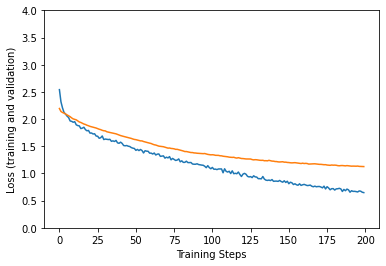

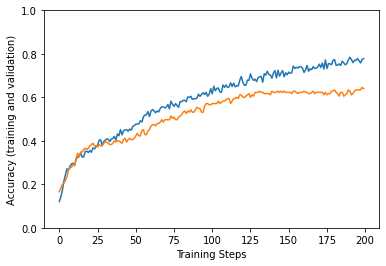

In [167]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,4])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

**Checking the performance**

In [168]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [169]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Blackhead' 'Eksim' 'Flekhitam' 'Herves' 'Jerawat' 'Kurap' 'Milia' 'Panu'
 'Rosacea']


In [170]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 9)


In [171]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Blackhead' 'Jerawat' 'Panu' 'Eksim' 'Blackhead' 'Jerawat' 'Panu' 'Kurap'
 'Eksim' 'Milia' 'Eksim' 'Rosacea' 'Panu' 'Blackhead' 'Kurap' 'Eksim'
 'Jerawat' 'Eksim' 'Jerawat' 'Eksim' 'Flekhitam' 'Flekhitam' 'Flekhitam'
 'Flekhitam' 'Jerawat' 'Blackhead' 'Flekhitam' 'Blackhead' 'Jerawat'
 'Panu' 'Jerawat' 'Jerawat']


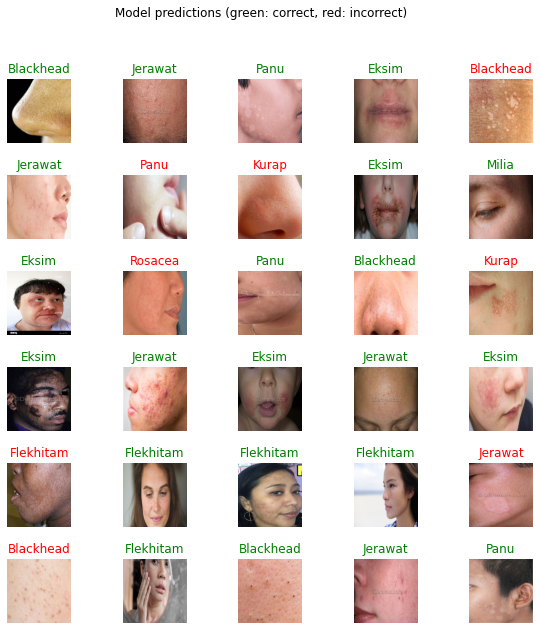

In [172]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [113]:
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

tfmodel = converter.convert()
open('sisdec.tflite', 'wb').write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmp5k0l2nrk/assets


INFO:tensorflow:Assets written to: /tmp/tmp5k0l2nrk/assets


2689248